**Exercice 1: General Statistics**

In [1]:
# Loading librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import seaborn as sns
from collections import Counter
import re
import string

In [2]:
# Loading Data Set
df = pd.read_csv('data/groover_dataset_challenge.csv', delimiter = ",")
print('The data has {0} rows and {1} columns'.format(df.shape[0], df.shape[1]))
print('-----------------------------')
df

The data has 10000 rows and 6 columns
-----------------------------


,Unnamed: 0,id,band_id,influencer_id,feedback,score
0,0,920636,24665,1642,"Bonjour Diogo Ramos,\n\n\nMerci pour le partag...",0.00
1,1,920637,24665,118,"Un message touchant, développé sur une onde mu...",0.00
2,2,920639,24665,226,Bonjour ! Merci beaucoup pour l'envoi ! On n'e...,0.00
3,3,920640,24665,1603,Bonjour. Merci pour cette fraîcheur et cet hym...,1.00
4,4,920641,24665,111,"Salut Diogo, alors c'est un peu éloigné de ce ...",1.00
...,...,...,...,...,...,...
9995,9995,936179,30049,3499,"Hey guys, thanks for sharing, great sound, alt...",1.00
9996,9996,936241,33795,2570,"Hello MD One, thank you for your track Bombe A...",0.00
9997,9997,936266,18877,2598,Hi! Thanks for sharing your track! I really li...,1.00
9998,9998,936274,18877,3179,This is an exceptionally produced electro-pop ...,0.25


In [ ]:
# separate variables into index data Frames
numeric_data = df.select_dtypes(include = [np.number])
cat_data = df.select_dtypes(exclude = [np.number])
print("There are {} numeric and {} categorical columns in data".format(numeric_data.shape[1], cat_data.shape[1]))
print("-------------------------")

# Remove the Id variable
del numeric_data['Unnamed: 0']
del numeric_data['id']


# Check data set information
df.info()

On dispose donc de 5 variables: 4 variables numériques (id, band_id, influencer_id, et score), et une variable textuelle qu'on va devoir traiter en utilisant les techniques de Text Mining en NLP (Natural Language Processing). Le score est la variable à prédire. On enlève la variable "Id" qui ne servira pas à la prédiction.

In [ ]:
print('The number of band is: {0}'.format(len(df['band_id'].unique())))
print('------------------------------')
print('The number of influencer is: {0}'.format(len(df['influencer_id'].unique())))

Le nombre de groupe de musiciens est: 970, et le nombre de groupe d'influenceur est 898. Donc en moyenne, le nombre de groupe de musiciens par influenceur est: 970/898 est à peu près: 1.08.

In [3]:
# Check if the data set has any missing values
df.columns[df.isnull().any()]

Index([], dtype='object')

La data ne contient pas des valeurs manquantes.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


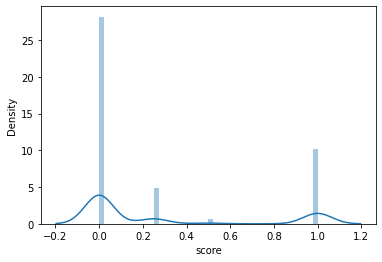

In [4]:
# Check the distribution of the target variable
sns.distplot(df['score'])

On remarque donc que la target Score est une variable discrete qui peut prendre 4 valeurs: 0, 0.25, 0.5, et 1. La plupart des Feedback sont désagréables ( étiquetés par 0).

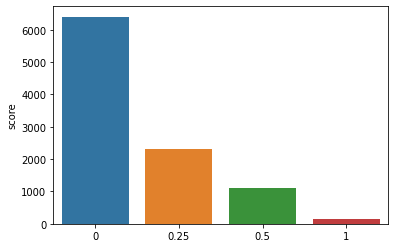

In [5]:
# Barplot score for each aband in the dataset
sns.barplot(x=[str(0), str(0.25), str(0.5), str(1)], y=df['score'].value_counts());

On se rend compte aussi que les valeurs de score pour les feedback ne sont pas forcémenet équilibrés dans le jeu de données. C'est un biais d'apprentissage qu'il faut prendre en compte dans la prédiction.

In [6]:
# Count the number of members in each band and select the band_id which corresponds to the maximum of artist 
list_band_id = df['band_id'].unique()
count_band = {}
for i in range(len(list_band_id)):
  count_band[str(list_band_id[i])] = (df['band_id'].tolist()).count(list_band_id[i])

inverse = [(value, key) for key, value in count_band.items()]
print(max(inverse)[1])

603


In [7]:
# Select rows corresponding to the maximum of members in bands
max_band = df[['band_id','influencer_id', 'feedback', 'score']].query('band_id == 603')
max_band

,band_id,influencer_id,feedback,score
946,603,2768,The video is made beautifully and I love your ...,0.25
947,603,2443,Bonsoir et merci pour ce nouvel envoi mais com...,0.00
948,603,2876,"Dear Magon,\n\nthe track is pretty ok but it d...",0.00
949,603,2000,Ciao sono Marco Racchella MRP75 direttore arti...,0.50
950,603,3441,"Hello! \nI liked your music, it is very good. ...",0.25
...,...,...,...,...
1110,603,3092,Très intéressant!\nLe choix d'utiliser cette b...,0.25
1111,603,2557,Hello and thank you for sending your music. An...,1.00
2867,603,3565,La chanson est très intéressante au niveau son...,0.25
2868,603,3582,This song remember some lo-fi nineties sounds ...,0.25


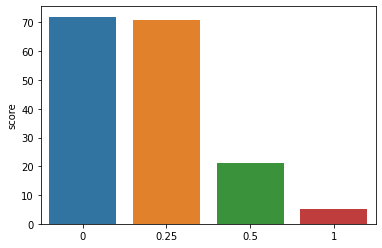

In [8]:
# Barplot score for each aband in the dataset
sns.barplot(x=[str(0), str(0.25), str(0.5), str(1)], y=max_band['score'].value_counts());

Dans cette sous partie on va faire une analyse des feedback.

In [9]:
# Check the feedback
print('------------------Band: {0}-----------'.format(np.array(df['band_id'])[0]), '\n')
print('The feedback is: {0}'.format(np.array(df['feedback'])[0]))
print('The score is: {0}'.format(np.array(df['score'])[0]), '\n')

print('------------------Band: {0}-----------'.format(np.array(df['band_id'])[9997]), '\n')
print('The feedback is: {0}'.format(np.array(df['feedback'])[9997]))
print('The score is: {0}'.format(np.array(df['score'])[9997]))

------------------Band: 24665----------- 

The feedback is: Bonjour Diogo Ramos,


Merci pour le partage.
Actuellement le titre ne correspond pas à notre ligne de programmation.

N'hésitez pas à nous envoyer vos prochains sons.

Bonne continuation,


André
Le Labo

The score is: 0.0 

------------------Band: 18877----------- 

The feedback is: Hi! Thanks for sharing your track! I really like this song. It really gave me good vibes whilst listening to it and I'd love to share in on my Instagram Stories!
The score is: 1.0


On remarque donc que d'après les scores de feedback. l'étiquette 1 correspond à un feedback agréable, et 0 correspond à un feedback négatif. On remarque aussi qu'il y a des commentaires en anglais, et des commentaires en français. Ceci est à prendre en compte pendant le traitement du texte ( Notamment pendant la suppression des stopwords, lemmatization, etc).

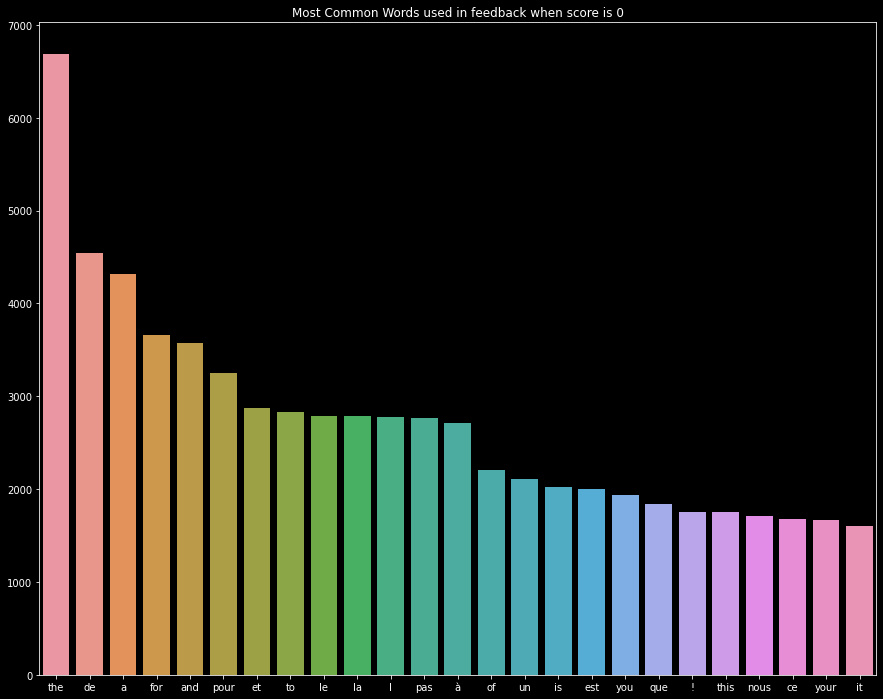

In [10]:
score_neg = df[df['score'] == 0.0]
score_neg_text = ' '.join(text for text in score_neg['feedback'])
score_neg_list = score_neg_text.split()
score_neg_counts = Counter(score_neg_list)
score_neg_common_words = [word[0] for word in score_neg_counts.most_common(25)]
score_neg_common_counts = [word[1] for word in score_neg_counts.most_common(25)]

plt.style.use('dark_background')
plt.figure(figsize=(15, 12))

sns.barplot(x=score_neg_common_words, y=score_neg_common_counts)
plt.title('Most Common Words used in feedback when score is 0');

On a donc beaucoup de mots commun comme "the", "de", "a" qui ne nous intéressent pas, car ils appartiennent au liste des stopwords. On va donc devoir nettoyer les textes.

**Exercice 2: Preprocessing Natural Language**

In [11]:
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.collocations import *

# Tokenzation
nltk.download('punkt')

# Stopwords in english
try:
    stopwords_english = set(stopwords.words('english'))
except LookupError:
    import nltk
    nltk.download('stopwords')
    stopwords_english = set(stopwords.words('english'))

# Stopwords in French
try:
    stopwords_french = set(stopwords.words('french'))
except LookupError:
    stopwords_french = set(stopwords.words('french'))

stopwords = stopwords_english.union(stopwords_french)

print('The number of stopwords in english is: {0}'.format(len(stopwords_english)))
print('------------------------------')
print('The number of stopwords in french is: {0}'.format(len(stopwords_french)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
The number of stopwords in english is: 179
------------------------------
The number of stopwords in french is: 157


Les stopwords sont les mots qui n’ont que peu d’intérêt sémantique comme les déterminants et les pronoms. NLTK dispose d’une liste de stopwords en anglais (179) et en français (157). Et comme on a dit précédemment, il faut prendre en compte les stopwords en anglais et en français.

Pour "nettoyer" le texte, on décompose le texte en des tokens (c'est à dire des unités lexicales du texte). Un token peut être aussi un signe de ponctuation. Et puis on enlève les stopwords. Et après on passe à la lemmatisation, cette méthode permet d'éliminer le genre ou le pluriel par exemple.

In [12]:
try:
  import spacy
  nlp = spacy.load('en_core_web_sm')
except Exception as e:
  print(e)

In [13]:
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)
# Cleanup text and make sure it retains original shape
print('Original data shape: ', df['feedback'].shape)
data_cleaned = cleanup_text(df['feedback'], logging=True)
print('Cleaned up data shape: ', data_cleaned.shape)

Original data shape:  (10000,)
Processed 1000 out of 10000 documents.
Processed 2000 out of 10000 documents.
Processed 3000 out of 10000 documents.
Processed 4000 out of 10000 documents.
Processed 5000 out of 10000 documents.
Processed 6000 out of 10000 documents.
Processed 7000 out of 10000 documents.
Processed 8000 out of 10000 documents.
Processed 9000 out of 10000 documents.
Processed 10000 out of 10000 documents.
Cleaned up data shape:  (10000,)


Après la tokenization, la suppresion des stopwords, et la lemmatisation. On "parse" notre docuemnt, c'est à dire on va parcourir tous les textes pour les mettres en forme avant de passer les dans le modèle.

In [14]:
# Parse documents
print('Parsing documents...')
train_vec = []
for doc in nlp.pipe(data_cleaned, batch_size=500):
    if doc.has_vector:
        train_vec.append(doc.vector)
    # If doc doesn't have a vector, then fill it with zeros.
    else:
        train_vec.append(np.zeros((128,), dtype="float32"))

train_vec = np.array(train_vec)

Parsing documents...


In [15]:
print('Total number of documents parsed: {}'.format(len(train_vec)))
print('Number of words in first document: ', len(df['feedback'][0]))
print('Number of words in second document: ', len(df['feedback'][1]))
print('Size of vector embeddings: ', train_vec.shape)
print('Shape of vectors embeddings matrix: ', train_vec.shape)

all_text = pd.DataFrame(df, columns=['feedback'])

print('Number of total text documents:', len(all_text))

Total number of documents parsed: 10000
Number of words in first document:  205
Number of words in second document:  202
Size of vector embeddings:  (10000, 96)
Shape of vectors embeddings matrix:  (10000, 96)
Number of total text documents: 10000


**Excercice 3: Fitting into analysis**

On utilise le modèle Word2Vec qui consitue un algorithme de Word embedding. Il permet d'apprendre des représentations vectorielles des mots composant un texte, de telle sorte que les mots qui partagent des contextes similaires soient représentés par des vecteurs numériques proches.

In [16]:
def cleanup_text_word2vec(docs, logging=False):
    sentences = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents" % (counter, len(docs)))
        # Disable tagger so that lemma_ of personal pronouns (I, me, etc) don't getted marked as "-PRON-"
        doc = nlp(doc, disable=['tagger'])
        # Grab lemmatized form of words and make lowercase
        doc = " ".join([tok.lemma_.lower() for tok in doc])
        # Split into sentences based on punctuation
        doc = re.split("[\.?!;] ", doc)
        # Remove commas, periods, and other punctuation (mostly commas)
        doc = [re.sub("[\.,;:!?]", "", sent) for sent in doc]
        # Split into words
        doc = [sent.split() for sent in doc]
        sentences += doc
        counter += 1
    return sentences

In [17]:
train_cleaned_word2vec = cleanup_text_word2vec(all_text['feedback'], logging=True)
print('Cleaned up data size (i.e. number of sentences): ', len(train_cleaned_word2vec))

Processed 1000 out of 10000 documents
Processed 2000 out of 10000 documents
Processed 3000 out of 10000 documents
Processed 4000 out of 10000 documents
Processed 5000 out of 10000 documents
Processed 6000 out of 10000 documents
Processed 7000 out of 10000 documents
Processed 8000 out of 10000 documents
Processed 9000 out of 10000 documents
Processed 10000 out of 10000 documents
Cleaned up data size (i.e. number of sentences):  42678


In [18]:
from gensim.models.word2vec import Word2Vec

text_dim = 300

print("Training Word2Vec model...")

wordvec_model = Word2Vec(train_cleaned_word2vec, size=text_dim, window=5, min_count=3, workers=4, sg=1)

print("Word2Vec model created.")
print("%d unique words represented by %d dimensional vectors" % (len(wordvec_model.wv.vocab), text_dim))

Training Word2Vec model...
Word2Vec model created.
7979 unique words represented by 300 dimensional vectors


In [19]:
# Define function to create word vectors given a cleaned piece of text.
def create_average_vec(doc):
    average = np.zeros((text_dim,), dtype='float32')
    num_words = 0.
    for word in doc.split():
        if word in wordvec_model.wv.vocab:
            average = np.add(average, wordvec_model[word])
            num_words += 1.
    if num_words != 0.:
        average = np.divide(average, num_words)
    return average

In [20]:
# Create word vectors
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", DeprecationWarning)

    train_cleaned_vec = np.zeros((df.shape[0], text_dim), dtype="float32")  # 19579 x 300
    for i in range(len(data_cleaned)):
        train_cleaned_vec[i] = create_average_vec(data_cleaned[i])

print("Train word vector shape:", train_cleaned_vec.shape)

Train word vector shape: (10000, 300)


In [21]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

# Transform labels into one hot encoded format.
score_string = {"score": {0.00: int(0), 0.25: int(1), 0.50: int(2), 1.00: int(3)}}
df = df.replace(score_string)
df["score"] = df["score"].astype(int)

y_train_ohe = label_binarize(df['score'], df['score'].unique())
print('y_train_ohe shape: {}'.format(y_train_ohe.shape))
print('y_train_ohe samples:')
print(y_train_ohe[:5])

X_train, X_test, y_train, y_test = train_test_split(train_cleaned_vec, y_train_ohe, test_size = 0.3)
print('------------------------------')
print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))

y_train_ohe shape: (10000, 4)
y_train_ohe samples:
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]]
------------------------------
X_train size: (7000, 300)
X_test size: (3000, 300)
y_train size: (7000, 4)
y_test size: (3000, 4)


Après l'entrainement du modèle Word2Vec, on va créer le réseau de neurones MLP ( Multi Layer Perceptron) pour faire la classification (4 classes). Le réseau comporte une couches d'entrée, 4 couches cachées, et une couche de sortie.

In [22]:
warnings.simplefilter("ignore", DeprecationWarning)
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import SGD

def build_model():
  model = Sequential()
        # Densely Connected Neural Network (Multi-Layer Perceptron)
  model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=300))
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
  model.add(Dropout(0.2))
  model.add(Dense(4, activation='softmax'))
  return model

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", DeprecationWarning)

    model = build_model()  #('mlp')
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               154112    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

On utilise commme optimizer SGD (Stochastic Gradient Descent)

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", DeprecationWarning)

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'])

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", DeprecationWarning)

    # Define number of epochs
    epochs = 50

    # Fit the model to the training data
    estimator = model.fit(X_train, y_train,
                          validation_split=0.2,
                          epochs=epochs, batch_size=128, verbose=100)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


Pour évaluer le modèle on utlise la métrique de la précision, on voit donc que score d'entrainement est de l'ordre de 81%, et celui du test est de 78.9% 

In [26]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" %
      (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 81.18% / Validation accuracy: 78.93%


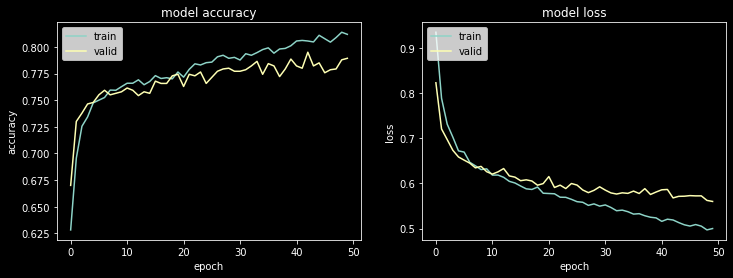

In [27]:
# Plot model accuracy over epochs
fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.reset_orig()   # Reset seaborn settings to get rid of black background
ax[0].plot(estimator.history['acc'])
ax[0].plot(estimator.history['val_acc'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'valid'], loc='upper left')

# Plot model loss over epochs
ax[1].plot(estimator.history['loss'])
ax[1].plot(estimator.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'valid'], loc='upper left');